In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import scipy.sparse
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import warnings
warnings.filterwarnings("ignore")
import string
sns.set_style("dark")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt
Saving val.txt to val.txt


In [3]:
train_data = pd.read_csv(
    "train.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
    encoding='latin-1'

)
test_data = pd.read_csv(
    "test.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
    encoding='latin-1'

)
validation_data = pd.read_csv(
    "val.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
    encoding='latin-1'

)

train_data = train_data.dropna(subset=['emotion'])
test_data = test_data.dropna(subset=['emotion'])
validation_data = validation_data.dropna(subset=['emotion'])

In [4]:
print("Train Data\n ", train_data.head(5))
print("---------------------------------------------------------------------------------")

print("Test Data\n", test_data.head(5))
print("---------------------------------------------------------------------------------")

print("Validation Data\n", validation_data.head(5))

Train Data
                                                  text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
---------------------------------------------------------------------------------
Test Data
                                                 text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
---------------------------------------------------------------------------------
Validation Data
                                                 tex

In [5]:
print(f"Number of entries in train_data: {train_data.shape[0]}")
print(f"Number of entries in test_data: {test_data.shape[0]}")
print(f"Number of entries in validation_data: {validation_data.shape[0]}")

Number of entries in train_data: 16125
Number of entries in test_data: 2002
Number of entries in validation_data: 2002


In [6]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        lower=False,
        upper=False,
        remove_special_characters=False,
        remove_punctuation=False,
        remove_stop_words=False,
        stem_the_words=False,
    ) -> None:
        self.lower = lower
        self.upper = upper
        self.remove_special_characters = remove_special_characters
        self.remove_punctuation = remove_punctuation
        self.remove_stop_words = remove_stop_words
        self.stem_the_words = stem_the_words
        super().__init__()

    def fit(self, X, y=None):
        return self

    # for converting the text to lower case
    def __convert_text_lower(self, text):
        text = text.lower()
        return text

    def __lower_text(self, X):
        X = X.apply(self.__convert_text_lower)
        return X

    # for converting the text to upper case
    def __convert_text_upper(self, text):
        text = text.upper()
        return text

    def __upper_text(self, X):
        X = X.apply(self.__convert_text_upper)
        return X

    # for converting the text to words
    def __TextToWord(self, X):
        words = word_tokenize(X)
        return words

    # for removing Special Characters
    def __remove_spec(self, X):
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if w.isalnum():
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Special_Characters(self, X):
        X = X.apply(self.__remove_spec)
        return X

    # for removing Punctuation
    def __remove_puncs(self, X):
        words = self.__TextToWord(X)
        punctuation = set(string.punctuation)
        fixed_words = []
        for w in words:
            if not punctuation.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Punctuation(self, X):
        X = X.apply(self.__remove_puncs)
        return X

    # for removing Stop Words
    def __remove_stop(self, X):
        stop_words = set(stopwords.words("english"))
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if not stop_words.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_stop_words(self, X):
        X = X.apply(self.__remove_stop)
        return X

    # for Stemming the words
    def __stem_text(self, text):
        stemmer = PorterStemmer()
        words = self.__TextToWord(text)
        stemmed_words = []
        for w in words:
            stemmed_words.append(stemmer.stem(w))
        return " ".join(stemmed_words)

    def __Stemming(self, X):
        X = X.apply(self.__stem_text)
        return X

    # we will apply the text processing based on the parameters
    def process_text(self, X):
        data = X.copy()
        # will lowercase the text
        if self.lower:
            data = self.__lower_text(data)
        # will uppercase the text
        if self.upper:
            data = self.__upper_text(data)
        # will remove the special characters
        if self.remove_special_characters:
            data = self.__Remove_Special_Characters(data)
        # will remove the punctuation
        if self.remove_punctuation:
            data = self.__Remove_Punctuation(data)
        # will remove the stop words
        if self.remove_stop_words:
            data = self.__Remove_stop_words(data)
        # will stem the words
        if self.stem_the_words:
            data = self.__Stemming(data)
        return data

    def transform(self, X, y=None):
        if isinstance(X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            # Convert sparse matrix to dense array for text processing
            X = pd.Series(X.toarray().ravel())  # Convert to Series for apply
            X = X.astype(str) # convert all to strings to apply .lower()
            X = self.process_text(X)
            # Convert back to sparse matrix if needed
            X = scipy.sparse.csr_matrix(X.values.reshape(1, -1)) # reshape to (1, num_features)
        else:
            X = self.process_text(X)
        return X

In [7]:
# removing Duplicate data
combine = [train_data, test_data, validation_data]
for data_set in combine:
    print(data_set.duplicated().sum()) #identifying duplicates
print( "---------------------------------------------------------------------------------")
for data_set in combine:
    data_set.drop_duplicates(inplace=True)#dropping duplicates
    print(data_set.duplicated().sum())

1
0
0
---------------------------------------------------------------------------------
0
0
0


In [8]:
train_x_train = train_data.text
train_y_train = train_data.emotion

test_x_test = test_data.text
test_y_test = test_data.emotion

validation_x_val = validation_data.text
validation_y_val = validation_data.emotion

In [9]:
label_encoder = LabelEncoder()
train_y_train = label_encoder.fit_transform(train_y_train)
test_y_test = label_encoder.transform(test_y_test)
validation_y_val = label_encoder.transform(validation_y_val)

In [10]:
label_encoder.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [11]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', C=1.0, random_state=42, probability=True))
])

pipeline.fit(train_x_train, train_y_train)


train_score = pipeline.score(train_x_train, train_y_train)
test_score = pipeline.score(test_x_test, test_y_test)
validation_score = pipeline.score(validation_x_val, validation_y_val)

print(f"\nFinal Accuracies:")
print(f"Training Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}, Validation Accuracy: {validation_score:.4f}\n")

joblib.dump(pipeline, 'svm_model.pkl')  # Save the model
# Access the TfidfVectorizer object from the pipeline using named_steps
tfidf_vectorizer = pipeline.named_steps['tfidf']
joblib.dump(tfidf_vectorizer, 'vectorizer.pkl') # Save the vectorizer


Final Accuracies:
Training Accuracy: 0.9539, Test Accuracy: 0.8801, Validation Accuracy: 0.8906



['vectorizer.pkl']

In [12]:
tfidf_vectorizer = pipeline.named_steps['tfidf']
num_features = len(tfidf_vectorizer.vocabulary_)
print(f"Number of features: {num_features}")

Number of features: 15214


In [13]:
def plot_confusion_matrix(model, X, y, title):
    """
    Plots the confusion matrix for the given model and data.

    Args:
        model: The trained model (pipeline).
        X: The data features.
        y: The data labels.
        title: The title for the confusion matrix plot.
    """
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

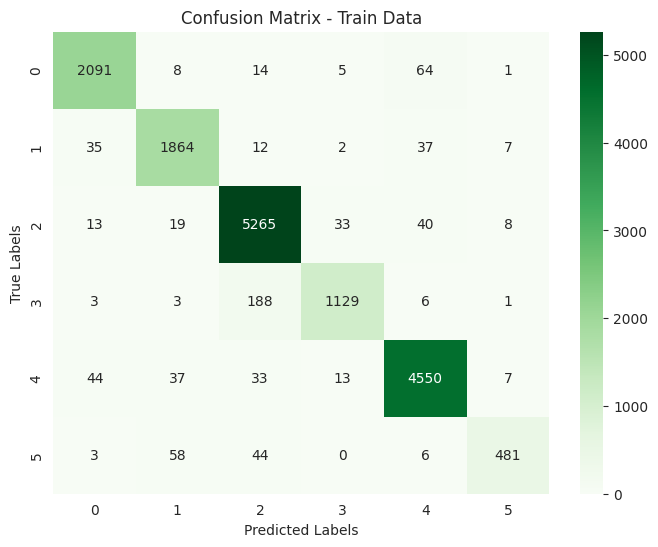

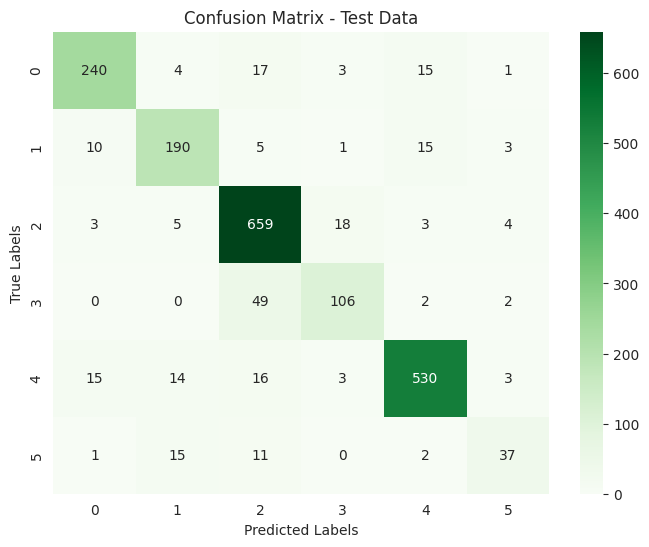

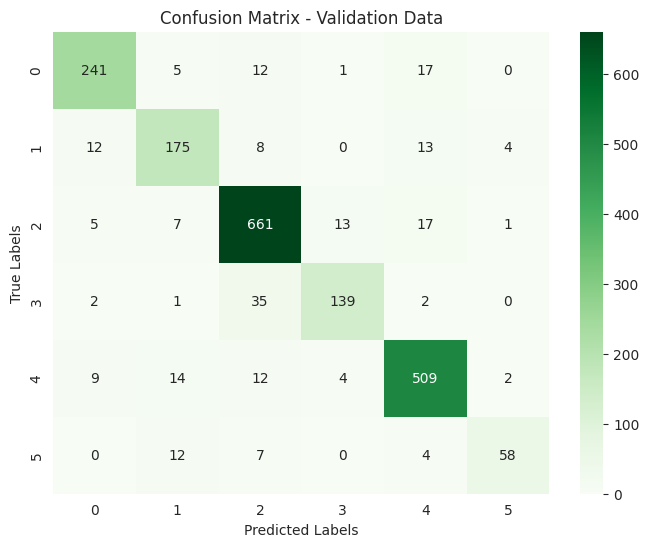

In [14]:
# Call the function to plot the confusion matrix for each dataset:
plot_confusion_matrix(pipeline, train_x_train, train_y_train, "Confusion Matrix - Train Data")
plot_confusion_matrix(pipeline, test_x_test, test_y_test, "Confusion Matrix - Test Data")
plot_confusion_matrix(pipeline, validation_x_val, validation_y_val, "Confusion Matrix - Validation Data")

In [19]:
def test_emotions_detection():
    svm_model = joblib.load('svm_model.pkl')

    # Define emotion labels corresponding to encoded values
    emotion_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

    user_input = input("Enter a sentence: ")
    # Calculate and print emotion percentages
    percentages = calculate_emotion_percentages(user_input, svm_model, emotion_labels)
    print("Emotion Percentages:")
    for emotion, percentage in percentages.items():
        print(f"{emotion}: {percentage:.2f}%")

In [20]:
def calculate_emotion_percentages(sentence, model, emotion_labels):
    """
    Calculates the percentage of each emotion in a sentence.

    Args:
        sentence: The input sentence.
        model: The trained emotion detection model.
        emotion_labels: A list of emotion labels corresponding to the model's output.

    Returns:
        A dictionary mapping emotion labels to their percentages in the sentence.
    """
    # Predict probabilities for each emotion
    probabilities = model.predict_proba(pd.Series([sentence]))[0]

    # Create a dictionary of emotion percentages
    emotion_percentages = {emotion_labels[i]: prob * 100 for i, prob in enumerate(probabilities)}

    return emotion_percentages

In [21]:
test_emotions_detection()

Enter a sentence: I hate you
Emotion Percentages:
anger: 47.39%
fear: 4.50%
joy: 8.52%
love: 1.34%
sadness: 37.87%
surprise: 0.39%
